## Homework 4: Automatic Differentiation Software + RNN's

In this final homework, we will look at neural networks. The point of this homework is not to teach you everything about neural networks, but to make them a little less scary and give you the option of using one in your research! You will get a walkthrough of pytorch, a popular automatic differentiation package, modify a simple neural network, and run an RNN used in research on genetic data.

### Automatic Differentiation
Automatic differentiation is an incredibly powerful tool that allows you to perform gradient descent without keeping track of and calculating gradients yourself! If you need a refresher, (or introduction) on gradient descent, there are many resources online, and [this one](https://towardsdatascience.com/understanding-the-mathematics-behind-gradient-descent-dde5dc9be06e) isn't bad. Come back when you are done to see the magic of gradient optimization in practice!

To start, you need to download the pytorch (<3) package, as is described [here.](https://pytorch.org/) Having installed this successfully, follow along in this notebook

In [1]:
# Confusingly, you use pytorch by importing torch, and we use these import torch.x as x
# because that is what you will often see in their libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)
import matplotlib.pyplot as plt
import numpy as np
import itertools

The first thing we are going to do is a toy linear regression example. This time, we aren't using a package to do it all for us. Instead, we are going to find the line of best fit by minimizing the mean squared error between the points and the prediction of the line. To minimize the error, we are going to follow the gradient of our error, or "loss" function (actually go in the opposite direction of the gradient). 


However, instead of using a formula for the gradient, we are going to just do the operations and let pytorch calculate the gradient for us. Take your time reading this code, things will build on these techniques.

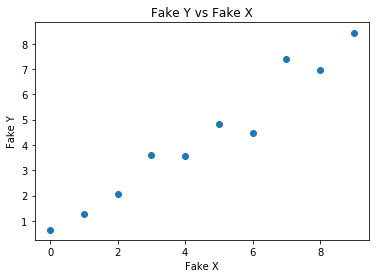

In [2]:
# First, let's initialize our dataset, which will have slope 1, 
# intercept 0, and gaussian noise added to each point. Let's see what
# it looks like:
x = torch.arange(10, dtype=torch.float32)
# torch.randn(10) returns a vector of length 10 with entries sampled from a normal
# distribution
y = x + torch.randn(10)
plt.scatter(x, y)
plt.title("Fake Y vs Fake X")
plt.xlabel("Fake X")
plt.ylabel("Fake Y")
plt.show()

Looks like a (rough) line! You may notice that some of those functions are also numpy functions! Pytorch has similar, but not identical, syntax to numpy, and much of the intuition you built up using numpy will apply here.

Now when you are doing numerical optimization, you have to initialize your hypotheses somehow (so you have something to optimize), so lets do that now. Our "hypothesis" is that the data x and labels y have the relationship y = m * x + b for some m and b.

In [3]:
# Requires grad tells pytorch it has to be ready to calculate the gradient for
# these variables
m = torch.tensor([-1], dtype=torch.float32, requires_grad=True)
b = torch.randn(1, requires_grad=True)

Now that we have a guess, let's plot!

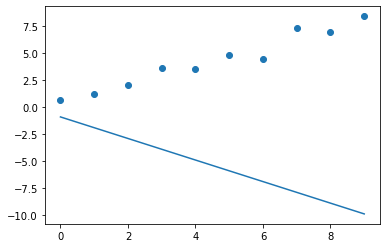

In [4]:
plt.scatter(x, y)
# We have to tell pytorch to not track this operation
with torch.no_grad():
    plt.plot(x.numpy(), (x*m + b).numpy())
plt.show()

Now that probably wasn't a good guess (if it was, reinitialize the variables). Let's tune our parameters to make a better fit.

In [5]:
# Learning rate is the hyperparameter that we set to make sure our steps are "local"
# because gradient only describes local behavior
learning_rate = 2e-3

# Let's keep track of the slopes and intercepts so we can visualize what we have done
slopes = []
intercepts = []
losses = []

# This is a training loop, something you will find universally in gradient descent. We
# need to take many little steps in the direction of the gradient
for i in range(100):
    
    # Notice vectorized operations
    prediction = b + m * x
    
    # Calculate the Mean Squared Error (MSE)
    loss = ((y - prediction) ** 2).mean()
    
    # This is again just for plotting our learning
    if i % 5 == 0:
        with torch.no_grad():
            slopes.append(m.clone().detach().numpy())
            intercepts.append(b.clone().detach().numpy())
    
    # Tell pytorch that these variables are important
    
    m.retain_grad()
    b.retain_grad()
    # After calculating loss, we can tell pytorch to calculate the gradient. 
    # This .backward() updates m.grad and b.grad to hold the gradients of the operations
    # we just did (specifically prediction and MSE calculation)
    loss.backward()
    with torch.no_grad():
        # Do the gradient descent step, notice MINIMIZING loss, so go in opposite
        # direction of gradient. 
        m -= learning_rate * m.grad
        b -= learning_rate * b.grad
    
    # Reset gradients to go around the loop again
    m.grad.zero_()
    b.grad.zero_()



Now let's check out all of the lines that we tried! Check out how the slope and intercept changed over time! It worked!

Slope: [-1.], Intercept: [-0.89229053]
Slope: [-0.06559217], Intercept: [-0.7371065]
Slope: [0.43591663], Intercept: [-0.65099365]
Slope: [0.7048822], Intercept: [-0.6020001]
Slope: [0.8489321], Intercept: [-0.5729619]
Slope: [0.92588186], Intercept: [-0.55465865]
Slope: [0.966789], Intercept: [-0.54213727]
Slope: [0.9883372], Intercept: [-0.53273696]
Slope: [0.99948853], Intercept: [-0.52502835]
Slope: [1.0050572], Intercept: [-0.5182433]
Slope: [1.0076293], Intercept: [-0.5119694]
Slope: [1.008594], Intercept: [-0.50598496]
Slope: [1.0086976], Intercept: [-0.50017065]
Slope: [1.0083411], Intercept: [-0.49446234]
Slope: [1.0077397], Intercept: [-0.48882556]
Slope: [1.007009], Intercept: [-0.48324174]
Slope: [1.0062112], Intercept: [-0.47770077]
Slope: [1.0053797], Intercept: [-0.47219706]
Slope: [1.0045322], Intercept: [-0.46672767]
Slope: [1.0036784], Intercept: [-0.46129087]


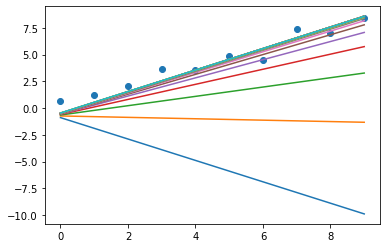

In [6]:
plt.figure()
plt.scatter(x.numpy(), y.numpy())
for m, b in zip(slopes, intercepts):
    print(f"Slope: {m}, Intercept: {b}")
    plt.plot(x.numpy(), (b+x.clone().numpy()*m))
plt.show()


### Neural Network Time!
Now we are going to create a neural network using this code. This is a big jump in complexity, but defining neural networks in pytorch is very formulaic, so if you take the time to understand this one it will be helpful for every neural network you see forever and ever. There are maybe more blog posts that describe how neural networks work than there are that describe gradient descent. 

[This book](http://neuralnetworksanddeeplearning.com/index.html) is very in depth and really guides you through math. If you want to go that deep, [this blogpost](https://victorzhou.com/blog/intro-to-neural-networks/) gives a shorter description and some intuition, and I highly recommend you at least check that out.

The big idea behind a neural network is that a neural network can be trained to approximate a function with example input and output data. A neural network is composed of a series of trainable parameters, all of which are either "weights" which are entries in a matrix that are analogous to the slope in the linear regression example or "biases" that are analogous to the intercept. That means "running" a (traditional feedforward) neural network is equivalent to doing a series of matrix multiplications and vector additions, calculating the gradient of the error with respect to each of these operations using .backward(), and taking a step in the appropriate direction.

The fact that automatic differetiation packages exist is a result of the [backpropogation](http://neuralnetworksanddeeplearning.com/chap2.html) algorithm, which is important to be aware of, but not necessary to fully understand in this excercise.

Let's see this in practice! We will be building a neural network that can calculate the parity (even or odd sum) of a list of a fixed length. This is a relatively easy task, which is good because it trains fast, but it is complex enough that we can see how neural networks might be useful for even more complex operations.

__Note:__ if you have never seen the softmax function before, you can read [this](https://towardsdatascience.com/softmax-function-simplified-714068bf8156) blogpost.

Let's take a look at the data we are going to be using:

In [7]:
def unique_perms(series):
    return {p for p in itertools.permutations(series)}

def construct_dataset(vec_len):
    example_list = [0] * vec_len
    data = [[0] * vec_len] 
    labels = [[1, 0]]
    for i in range(vec_len):
        example_list[i] = 1
        permutations = list(unique_perms(example_list))
        data.extend(permutations)
        labels.extend([[i % 2, (i + 1) % 2]] * len(permutations))
        
        
    return torch.FloatTensor(data), torch.FloatTensor(labels)

# If you want to see what the data and labels looks like, try:
# print(construct_dataset(3))


In [8]:
# This is the usual setup for a pytorch neural network. You make a class that inherits
# nn.Module, initialize parameters, and define a forward (a.k.a. predict) method.

class MyFirstNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        #This line is required, but not important
        super(MyFirstNetwork, self).__init__()
        
        # In this network we define two layers, a hidden layer and an output layer
        # Remember, these layers are just matrices of dimension arg1 X arg2 with
        # a vector of biases of dimension arg2 X 1. Pytorch combines that all into
        # a single layer, making things super easy
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # You can pass data through a layer by calling that layer like a function!
        # Check out below:
        layer1_output = self.layer1(x)
        h1 = F.relu(layer1_output)
        # One important part of many neural networks is adding a non-linearity
        # function. This increases the complexity of functions neural networks
        # can approximate. We are using the relu function in this example
        # (https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). We want
        # to use a non-linearity like relu after every layer (except for on the output
        # then we want to use softmax or something like that).
        layer2_output = self.layer2(h1)
        h2 = F.relu(layer2_output);
        
        # Now we run the output of the previous layer through the output layer. We 
        # ultimately want to output whether there is even (1,0) or odd (0,1) parity.
        # So we treat this output as representing unnormalized probabilities, or logits,
        # and use the softmax function so we get a vector that sums to one. We then
        # want to train the Network to output either (1, 0) or (0, 1), depending on
        # the input
        logits = self.layer3(h2)
        return F.softmax(logits, dim=1)

# Another training loop! This time we allow the loss calculation to be any function
# criterion, and we use pytorch's optimizer instead of doing the gradient descent by
# hand. Finally, epoch is the word we use for an iteration through all of the data.
# We are training on all of our data each step in this example, but you can also
# train on mini batches of your data, e.g. 32 examples at a time, if your dataset
# is big enough
def train(network, data_matrix, labels, criterion, optimizer, num_epochs = 1000):
    losses = []
    for epoch in range(num_epochs):
        # Zeroing the gradient like before
        optimizer.zero_grad()
        # Getting the prediction from our model on all of the data
        output = network(data_matrix)
        # Calculating loss
        loss = criterion(output, labels)
        losses.append(loss)
        # Calculate the gradients at each step
        loss.backward()
        # Take a step in the appropriate direction
        optimizer.step()
        
    return losses
        




Now that we have all of the pieces, we can put them together and train a neural network!

In [9]:
vector_len = 8
data, labels = construct_dataset(vector_len)

# Let's initialize our network
# our inputs will be length 8
input_size = vector_len
# A layer size that that feels right for our input size
hidden_size = 16
# our output will be a categorical distribution, (prob_even, prob_odd)
output_size = 2
# a hyperparameter (that you will change!)
learning_rate = 0.03

mynet = MyFirstNetwork(input_size, hidden_size, output_size)

# pytorch provides an mse calculator for us
criterion = nn.MSELoss()
# The optimizer we are using is called Adam, and it is like fancy gradient descent.
# Worth checking out, but for right now we just need to know that it converges
# faster on many problems. We pass the parameters, i.e. layers of our network to
# the optimizer so that it can track them and update them, and we give a learning rate
optimizer = optim.Adam(mynet.parameters(), lr=learning_rate)

In [10]:
# Let's see what our untrained network predicts!
print(mynet(torch.FloatTensor([0,0,0,0,0,0,0,1]).unsqueeze(0)))

tensor([[0.5695, 0.4305]], grad_fn=<SoftmaxBackward>)


It's not very sure either way, we can do much better than this

In [11]:
# Now let's put it all together and train the network!
losses = train(mynet, data, labels, criterion, optimizer)

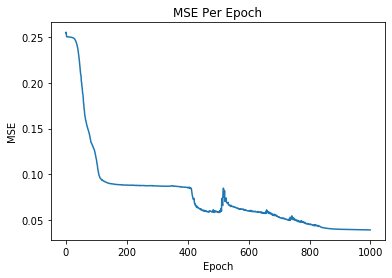

In [12]:
plt.plot(np.arange(len(losses)), losses)
plt.title("MSE Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

Now we can see what the network predicts when we run it on a datapoint.

In [13]:
mynet(torch.FloatTensor([1,0,0,0,0,0,0,0]).unsqueeze(0))

tensor([[0.0102, 0.9898]], grad_fn=<SoftmaxBackward>)

Now that we have a network to build off of, you are going to be tweaking different parts of the code so that you get more comfortable working with pytorch. You are going to get some practice plotting here. With each tweak, plot the original loss curve and the new loss curve after the tweak. 
1. Change the learning rate. Try differing by orders of 3x in both directions, and plot your results for 5 different learning rates. Plot 1 graph with all 5 loss curves.
2. Change the size of the hidden layer. Try a much lower value and see if the network can still learn well. What is the smallest that layer can be and still learn the function? Plot the results of five different attempts, again on the same graph.
3. Add another layer in myfirstnetwork to create mysecondnetwork. See if you can use 2 smaller hidden layers instead of one bigger layer. Don't forget the non-linearity!
4. (Optional) Split the training data into training and testing data. See if you can get the network to generalize to data it hasn't seen before. __Note__ You should always do this when you are training a real network, because overfitting is a very common problem. (i.e. your network fails to generalize)

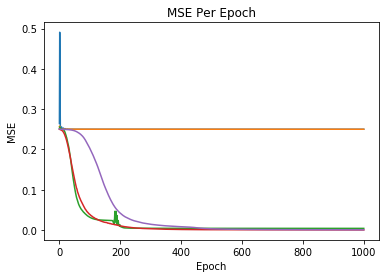

In [14]:
# Start coding here! 
#rate = 0.27
mynet1 = MyFirstNetwork(input_size, hidden_size, output_size)
optimizer1 = optim.Adam(mynet1.parameters(), lr=0.27)
losses1 = train(mynet1, data, labels, criterion, optimizer1)
#rate = 0.09
mynet2 = MyFirstNetwork(input_size, hidden_size, output_size)
optimizer2 = optim.Adam(mynet2.parameters(), lr=0.09)
losses2 = train(mynet2, data, labels, criterion, optimizer2)
#rate = 0.03
mynet3 = MyFirstNetwork(input_size, hidden_size, output_size)
optimizer3 = optim.Adam(mynet3.parameters(), lr=0.03)
losses3 = train(mynet3, data, labels, criterion, optimizer3)
#rate = 0.01
mynet4 = MyFirstNetwork(input_size, hidden_size, output_size)
optimizer4 = optim.Adam(mynet4.parameters(), lr=0.01)
losses4 = train(mynet4, data, labels, criterion, optimizer4)
#rate = 0.003
mynet5 = MyFirstNetwork(input_size, hidden_size, output_size)
optimizer5 = optim.Adam(mynet5.parameters(), lr=0.003)
losses5 = train(mynet5, data, labels, criterion, optimizer5)

plt.plot(np.arange(len(losses1)), losses1)
plt.plot(np.arange(len(losses2)), losses2)
plt.plot(np.arange(len(losses3)), losses3)
plt.plot(np.arange(len(losses4)), losses4)
plt.plot(np.arange(len(losses5)), losses5)
plt.title("MSE Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

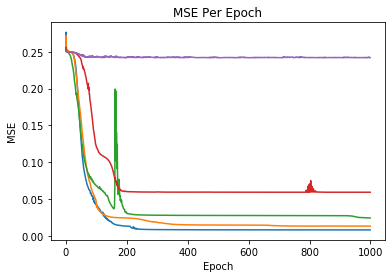

In [15]:
#hidden_size = 64
mynet1 = MyFirstNetwork(input_size, 64, output_size)
optimizer1 = optim.Adam(mynet1.parameters(), lr=learning_rate)
losses1 = train(mynet1, data, labels, criterion, optimizer1)
#hidden_size = 32
mynet2 = MyFirstNetwork(input_size, 32, output_size)
optimizer2 = optim.Adam(mynet2.parameters(), lr=learning_rate)
losses2 = train(mynet2, data, labels, criterion, optimizer2)
#hidden_size = 16
mynet3 = MyFirstNetwork(input_size, 16, output_size)
optimizer3 = optim.Adam(mynet3.parameters(), lr=learning_rate)
losses3 = train(mynet3, data, labels, criterion, optimizer3)
#hidden_size = 8
mynet4 = MyFirstNetwork(input_size, 8, output_size)
optimizer4 = optim.Adam(mynet4.parameters(), lr=learning_rate)
losses4 = train(mynet4, data, labels, criterion, optimizer4)
#hidden_size = 4
mynet5 = MyFirstNetwork(input_size, 4, output_size)
optimizer5 = optim.Adam(mynet5.parameters(), lr=learning_rate)
losses5 = train(mynet5, data, labels, criterion, optimizer5)

plt.plot(np.arange(len(losses1)), losses1)
plt.plot(np.arange(len(losses2)), losses2)
plt.plot(np.arange(len(losses3)), losses3)
plt.plot(np.arange(len(losses4)), losses4)
plt.plot(np.arange(len(losses5)), losses5)
plt.title("MSE Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

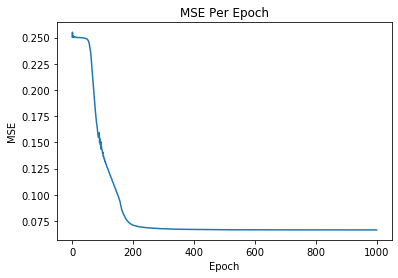

In [16]:
#2 hidden layers, each with 10 nodes
mynet1 = MyFirstNetwork(input_size, 10, output_size)
optimizer1 = optim.Adam(mynet1.parameters(), lr=learning_rate)
losses1 = train(mynet1, data, labels, criterion, optimizer1)

plt.plot(np.arange(len(losses1)), losses1)
plt.title("MSE Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

## RNN Time!

RNNs are inspired by HMMs and are used to process sequential data. If you need a refresher on RNNs, check out [this blogpost.](https://towardsdatascience.com/learn-how-recurrent-neural-networks-work-84e975feaaf7) We will be implementing a vanilla recurrent neural network because it is conceptually the simplest, but it is very rare you would see one in the wild. Long-Short Term Memory networks (LSTMs) or GRUs are much more common in the real world, but are just variations on the key ideas you will see below.

__Side note:__ you can use tqdm for easy progress bars, pretty cool

In [17]:
from tqdm import tqdm_notebook as tqdm

We are going to construct a slightly different dataset to train the RNN. You may recall that an RNN outputs something at each timestep, and so to give it a stronger signal we will label each element with the parity so far in the sequence, as we want the RNN to be able to distinguish between even and odd summed sequences of any length.

In [18]:
def unique_perms(series):
    return {p for p in itertools.permutations(series)}

def construct_rnn_dataset(vec_len):
    example_list = [0] * vec_len
    data = [[0] * vec_len] 
    labels = [[0] * vec_len]
    for i in range(vec_len):
        example_list[i] = 1
        permutations = list(unique_perms(example_list))
        data.extend(permutations)
        for perm in permutations:
            labels.append([sum(perm[:i+1]) % 2 for i in range(len(perm))])
        
        
    return torch.FloatTensor(data), torch.LongTensor(labels)

Your task is to fill out the forward function for this RNN. You may want to use MyFirstNetwork as inspiration. ```forward``` gives the output and hidden state after one timestep of the network. ```forward_predict``` gives you an idea of how forward would be used to run your RNN on an entire sequence.

At each timestep:
<pre>
prev_hidden                              ----------> |i2o| ---------------> output
    +        -----> |input2hidden1| -----|
  input                                  ----------> |input2hidden2|------> hidden
</pre>
Don't forget to put nonlinearities after each layer (to make the network more expressive) and a softmax on the output (because we are classifying each sequence as either even or odd).

In [19]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        # This should look familiar!
        self.hidden_size = hidden_size
        self.input2hidden1 = nn.Linear(input_size + hidden_size, input_size + hidden_size)
        self.input2hidden2 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        # We will start you off with the torch.cat function
        combined = torch.cat((input, hidden), -1)
        
        # How do we get from combined to our new output and hidden?
        layer1_output = self.input2hidden1(combined)
        h1 = F.relu(layer1_output)
        
        layer2_output1 = self.i2o(h1)
        output = self.softmax(layer2_output1)
        
        layer2_output2 = self.input2hidden2(h1)
        hidden2 = self.softmax(layer2_output2)
                
        
        return output, hidden2

    def forward_predict(self, sequence):
        h = self.init_hidden(1)
        for e in sequence:
            o, h = self.forward(e.reshape(1,1), h)
        return o
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

def train(network, data_matrix, labels, criterion, optimizer, num_epochs = 200):
    losses = []
    # This should look familiar too!
    for epoch in tqdm(range(num_epochs)):
        # Zero out the gradient and initialize the loss...
        optimizer.zero_grad()
        loss = torch.tensor(0.)
        hidden = network.init_hidden(data_matrix.shape[0])
        

        # Getting the prediction from our model on all of the data
        # at each timestep, and calculating the error in parity prediction
        for i in range(data_matrix.shape[1]):
            output, hidden = network(data_matrix[:,i].unsqueeze(1), hidden)
            loss += criterion(output, labels[:,i]) / data_matrix.shape[1]
        
        losses.append(loss)
        # Calculate the gradients at each step
        loss.backward()
        # Take a step in the appropriate direction
        optimizer.step()
        
    return losses
        

Ok, now let's construct our dataset and labels!

In [20]:
data, labels = construct_rnn_dataset(5)

This time when we train, we will use CrossEntropyLoss instead of MSE loss. Cross entropy loss is more appropriate for training a classifier, as it treats output as probabilities so you can get a stronger gradient for a 0-1 flip.

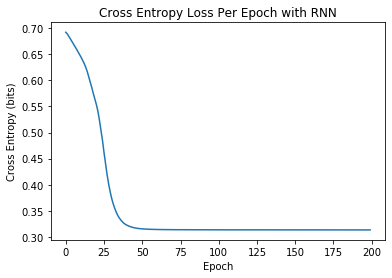

In [21]:
input_size = 1
hidden_size = 20
output_size = 2
criterion = nn.CrossEntropyLoss()
mynet = RNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(mynet.parameters(), lr=.03)
losses = train(mynet, data, labels, criterion, optimizer)

plt.plot(np.arange(len(losses)), losses)

    
plt.title("Cross Entropy Loss Per Epoch with RNN")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy (bits)")
plt.show()

In [22]:
# Now that we have trained the network, if all is good we should be able to classify
# a sequence of many lengths using forward predict. Try it out below and see for yourself!
print(mynet.forward_predict(torch.FloatTensor([1,0,0,1,0,1,1,0,0,0,0,1])))

print(mynet.forward_predict(torch.FloatTensor([1,0,0,1,0,1,1,0,0,0,1])))

print(mynet.forward_predict(torch.FloatTensor([1,1])))

print(mynet.forward_predict(torch.FloatTensor([1,0,0,1,0,1,1,1])))

print(mynet.forward_predict(torch.FloatTensor([1,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,1,0,0])))

tensor([[2.1727e-05, 9.9998e-01]], grad_fn=<SoftmaxBackward>)
tensor([[2.1727e-05, 9.9998e-01]], grad_fn=<SoftmaxBackward>)
tensor([[9.9957e-01, 4.2921e-04]], grad_fn=<SoftmaxBackward>)
tensor([[1.2078e-05, 9.9999e-01]], grad_fn=<SoftmaxBackward>)
tensor([[9.9999e-01, 1.2155e-05]], grad_fn=<SoftmaxBackward>)
